In [2]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import datasets
from torchvision import transforms
from torchsummary import summary
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
SEED = 1

cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print("Device", device)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

Device cuda


In [4]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                      transforms.RandomAffine(degrees=15, translate=(0.1,0.1), scale=(0.9, 1.1)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [5]:
train_data = datasets.CIFAR10('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10('../data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:06<00:00, 24417483.26it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [6]:
kwargs = {'batch_size': 128, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

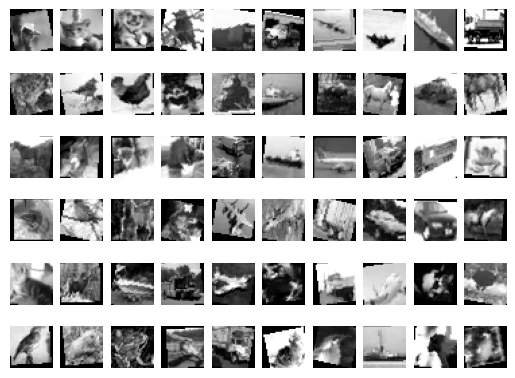

In [7]:
images, labels = next(iter(train_loader))
#print(images[0,1:].numpy().squeeze())


figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index][1:][1:].numpy().squeeze(),cmap="gray")

In [13]:
groups = 4

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(groups,16),
            nn.Dropout(0.10)
        ) # output_size = 30

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(groups,32),
            nn.Dropout(0.10)
        ) # output_size = 28

        #Adding AntMan and MaxPool
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 28
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 14

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(groups,16),
            nn.Dropout(0.10)
        ) # output_size = 14

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(groups,32),
            nn.Dropout(0.10)
        ) # output_size = 12

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(groups,32),
            nn.Dropout(0.10)
        ) # output_size = 12

        #Adding AntMan and MaxPool
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 12
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 6

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(groups,16),
            nn.Dropout(0.10)
        ) # output_size = 6

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(groups,32),
            nn.Dropout(0.10)
        ) # output_size = 4

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(groups,64),
            nn.Dropout(0.10)
        ) # output_size = 4

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1

        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.pool2(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.gap(x)
        x = self.convblock11(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [14]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             432
              ReLU-2           [-1, 16, 30, 30]               0
         GroupNorm-3           [-1, 16, 30, 30]              32
           Dropout-4           [-1, 16, 30, 30]               0
            Conv2d-5           [-1, 32, 28, 28]           4,608
              ReLU-6           [-1, 32, 28, 28]               0
         GroupNorm-7           [-1, 32, 28, 28]              64
           Dropout-8           [-1, 32, 28, 28]               0
            Conv2d-9           [-1, 16, 28, 28]             512
        MaxPool2d-10           [-1, 16, 14, 14]               0
           Conv2d-11           [-1, 16, 14, 14]           2,304
             ReLU-12           [-1, 16, 14, 14]               0
        GroupNorm-13           [-1, 16, 14, 14]              32
          Dropout-14           [-1

In [15]:
#Function for calculating correct predictions
def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train() #Setting model in train mode
  pbar = tqdm(train_loader) #Loading bar

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad() #To prevent gradient accumulation

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  return (100*correct/processed,train_loss/len(train_loader))

#Model testing
def test(model, device, test_loader, criterion):
    model.eval() #Put model in test mode

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return (100. * correct / len(test_loader.dataset),test_loss)

In [16]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) #For adjusting weights post error calculation
criterion = F.nll_loss

In [17]:
epochs = 20
train_losses = []
test_losses = []
train_acc = []
test_acc = []

for epoch in range(1,epochs+1):
    print(f'Epoch {epoch}')
    train_accuracy, train_loss = train(model, device, train_loader, optimizer, criterion)
    train_losses.append(train_loss)
    train_acc.append(train_accuracy)
    test_accuracy, test_loss = test(model, device, test_loader, criterion)
    test_acc.append(test_accuracy)
    test_losses.append(test_loss)

Epoch 1


Train: Loss=1.4908 Batch_id=390 Accuracy=32.49: 100%|██████████| 391/391 [00:35<00:00, 11.09it/s]


Test set: Average loss: 1.4891, Accuracy: 4542/10000 (45.42%)

Epoch 2


Train: Loss=1.5030 Batch_id=390 Accuracy=44.91: 100%|██████████| 391/391 [00:36<00:00, 10.79it/s]


Test set: Average loss: 1.4033, Accuracy: 4857/10000 (48.57%)

Epoch 3


Train: Loss=1.1045 Batch_id=390 Accuracy=49.70: 100%|██████████| 391/391 [00:34<00:00, 11.23it/s]


Test set: Average loss: 1.2661, Accuracy: 5431/10000 (54.31%)

Epoch 4


Train: Loss=1.2250 Batch_id=390 Accuracy=53.43: 100%|██████████| 391/391 [00:35<00:00, 11.15it/s]


Test set: Average loss: 1.1704, Accuracy: 5805/10000 (58.05%)

Epoch 5


Train: Loss=1.1096 Batch_id=390 Accuracy=56.12: 100%|██████████| 391/391 [00:36<00:00, 10.72it/s]


Test set: Average loss: 1.1027, Accuracy: 6075/10000 (60.75%)

Epoch 6


Train: Loss=1.0047 Batch_id=390 Accuracy=57.99: 100%|██████████| 391/391 [00:35<00:00, 11.08it/s]


Test set: Average loss: 1.1250, Accuracy: 5966/10000 (59.66%)

Epoch 7


Train: Loss=1.2098 Batch_id=390 Accuracy=59.90: 100%|██████████| 391/391 [00:35<00:00, 11.14it/s]


Test set: Average loss: 1.0008, Accuracy: 6445/10000 (64.45%)

Epoch 8


Train: Loss=1.0096 Batch_id=390 Accuracy=61.51: 100%|██████████| 391/391 [00:35<00:00, 11.13it/s]


Test set: Average loss: 1.0153, Accuracy: 6328/10000 (63.28%)

Epoch 9


Train: Loss=0.8140 Batch_id=390 Accuracy=62.94: 100%|██████████| 391/391 [00:34<00:00, 11.21it/s]


Test set: Average loss: 1.0032, Accuracy: 6443/10000 (64.43%)

Epoch 10


Train: Loss=1.0838 Batch_id=390 Accuracy=62.95: 100%|██████████| 391/391 [00:35<00:00, 11.11it/s]


Test set: Average loss: 0.9095, Accuracy: 6736/10000 (67.36%)

Epoch 11


Train: Loss=0.9479 Batch_id=390 Accuracy=64.08: 100%|██████████| 391/391 [00:36<00:00, 10.63it/s]


Test set: Average loss: 0.8958, Accuracy: 6829/10000 (68.29%)

Epoch 12


Train: Loss=0.8893 Batch_id=390 Accuracy=64.76: 100%|██████████| 391/391 [00:35<00:00, 10.98it/s]


Test set: Average loss: 0.9235, Accuracy: 6741/10000 (67.41%)

Epoch 13


Train: Loss=0.8879 Batch_id=390 Accuracy=65.46: 100%|██████████| 391/391 [00:35<00:00, 11.03it/s]


Test set: Average loss: 0.8729, Accuracy: 6907/10000 (69.07%)

Epoch 14


Train: Loss=0.9215 Batch_id=390 Accuracy=66.17: 100%|██████████| 391/391 [00:36<00:00, 10.76it/s]


Test set: Average loss: 0.8779, Accuracy: 6880/10000 (68.80%)

Epoch 15


Train: Loss=0.9652 Batch_id=390 Accuracy=66.46: 100%|██████████| 391/391 [00:36<00:00, 10.83it/s]


Test set: Average loss: 0.8111, Accuracy: 7149/10000 (71.49%)

Epoch 16


Train: Loss=0.8348 Batch_id=390 Accuracy=67.13: 100%|██████████| 391/391 [00:36<00:00, 10.70it/s]


Test set: Average loss: 0.8205, Accuracy: 7112/10000 (71.12%)

Epoch 17


Train: Loss=0.9493 Batch_id=390 Accuracy=67.39: 100%|██████████| 391/391 [00:35<00:00, 11.03it/s]


Test set: Average loss: 0.7913, Accuracy: 7211/10000 (72.11%)

Epoch 18


Train: Loss=1.0292 Batch_id=390 Accuracy=68.05: 100%|██████████| 391/391 [00:35<00:00, 11.03it/s]


Test set: Average loss: 0.7739, Accuracy: 7282/10000 (72.82%)

Epoch 19


Train: Loss=1.0363 Batch_id=390 Accuracy=68.22: 100%|██████████| 391/391 [00:35<00:00, 11.10it/s]


Test set: Average loss: 0.8001, Accuracy: 7178/10000 (71.78%)

Epoch 20


Train: Loss=0.8774 Batch_id=390 Accuracy=68.76: 100%|██████████| 391/391 [00:35<00:00, 11.04it/s]


Test set: Average loss: 0.7889, Accuracy: 7216/10000 (72.16%)

